# Classification pour Pombourg / weak supervision

Pour tester l'ensemble des /labelling functions/, c'est mieux d'avoir un jeu déjà labelisé, même si ce dernier n'est pas exhaustif.

C'est pourquoi il faut extraire les /features/ des échantillons labélisés.

## Imports

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

In [3]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [5]:
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling import LabelModel
from snorkel.utils import preds_to_probs

In [6]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

Using TensorFlow backend.


In [7]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [8]:
plt.style.use("seaborn-notebook")

In [9]:
from geo3dfeatures.io import las as read_las
from geo3dfeatures.extract import compute_tree, request_tree, extract
from geo3dfeatures.features import max_normalize, sum_normalize
from geo3dfeatures.tools.kmean import load_features

In [10]:
DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

## Données

In [11]:
PREFIX_NAME = "Pombourg"
SCENE_FILE = PREFIX_NAME + ".las"
EBOULIS_FILE = PREFIX_NAME + "_eboulis.las"
VEGETATION_FILE = PREFIX_NAME + "_vegetation.las"
FALAISE_FILE = PREFIX_NAME + "_falaise.las"

In [12]:
DATADIR = Path("/home/dag/data/geolithe-univers/workspace")

In [13]:
EBOULIS = 0
FALAISE = 1
VEGETATION = 2
UNKNOWN = -1
LABELS = {"eboulis": EBOULIS,
          "falaise": FALAISE,
          "vegetation": VEGETATION}
VOISINS = [50, 200, 1500]

In [14]:
# Labels des coordonnées
COORDS = list("xyz")
# Labels du channel RGB (couleurs)
COULEURS = list("rgb")

In [12]:
rawdata = read_las(DATADIR / "input" / SCENE_FILE)
rawdata = pd.DataFrame(rawdata, columns=list("xyzrgb"))

In [13]:
print("dimension: ", rawdata.shape)
rawdata.head()

dimension:  (672193, 6)


,x,y,z,r,g,b
0,1.977540e+06,5.242311e+06,902.684203,128.0,88.0,75.0
1,1.977540e+06,5.242311e+06,902.674986,117.0,78.0,66.0
2,1.977540e+06,5.242311e+06,902.731627,111.0,73.0,62.0
3,1.977538e+06,5.242330e+06,893.093306,147.0,135.0,131.0
4,1.977538e+06,5.242330e+06,893.049910,149.0,137.0,133.0


## Lecture des features pour n=50 200 1500

In [15]:
features = load_features(DATADIR, PREFIX_NAME, [50, 200, 1500])

[13:51:53] kmean.load_features (INFO) - Recover features stored in /home/dag/data/geolithe-univers/workspace/output/Pombourg/features/features.h5
[13:51:53] utils._init_num_threads (INFO) - NumExpr defaulting to 4 threads.


In [16]:
features.shape

(672193, 63)

In [17]:
features.head()

,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,planarity_1500,scattering_1500,omnivariance_1500,anisotropy_1500,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500
0,1.977525e+06,5.242324e+06,891.317748,0.334604,0.664243,2.055300,0.292404,0.085410,1.429846,0.312858,...,0.349891,0.001678,0.061972,0.998322,0.582007,1122.339474,2.042213,114.635222,917.769528,0.274770
1,1.977525e+06,5.242324e+06,891.319029,0.345110,0.653892,2.030211,0.279770,0.082896,1.483513,0.315099,...,0.360852,0.001681,0.062153,0.998319,0.588088,1113.190733,2.001808,119.309563,913.282079,0.279151
2,1.977525e+06,5.242324e+06,891.354063,0.305694,0.692340,2.015489,0.298752,0.088161,1.516258,0.308114,...,0.354059,0.001692,0.062200,0.998308,0.584418,1117.264330,1.995458,120.070114,911.133084,0.280125
3,1.977525e+06,5.242324e+06,891.390135,0.295625,0.702156,1.980571,0.312424,0.092636,1.597878,0.304651,...,0.356062,0.001723,0.062601,0.998277,0.585683,1114.302199,1.969498,123.256208,904.931612,0.285944
4,1.977525e+06,5.242324e+06,891.310728,0.335228,0.663748,2.011791,0.271698,0.080073,1.524637,0.316415,...,0.361747,0.001637,0.061615,0.998363,0.588348,1113.519679,2.010107,118.326412,918.530668,0.275069


In [18]:
features.columns

Index(['x', 'y', 'z', 'alpha_50', 'beta_50', 'radius_50', 'z_range_50',
       'std_dev_50', 'density_50', 'verticality_50', 'curvature_change_50',
       'linearity_50', 'planarity_50', 'scattering_50', 'omnivariance_50',
       'anisotropy_50', 'eigenentropy_50', 'eigenvalue_sum_50', 'radius_2D_50',
       'density_2D_50', 'eigenvalue_sum_2D_50', 'eigenvalue_ratio_2D_50', 'r',
       'g', 'b', 'alpha_200', 'beta_200', 'radius_200', 'z_range_200',
       'std_dev_200', 'density_200', 'verticality_200', 'curvature_change_200',
       'linearity_200', 'planarity_200', 'scattering_200', 'omnivariance_200',
       'anisotropy_200', 'eigenentropy_200', 'eigenvalue_sum_200',
       'radius_2D_200', 'density_2D_200', 'eigenvalue_sum_2D_200',
       'eigenvalue_ratio_2D_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'std_dev_1500', 'density_1500', 'verticality_1500',
       'curvature_change_1500', 'linearity_1500', 'planarity_1500',
       'scattering_1500', 'omnivari

## Features selection

### Lecture des features par échantillon (hdf5)

In [27]:
KEY_H5_FORMAT = "/num_{:04d}"

def concat_columns(filepath, neighbors):
    "Concaténation d'un ensemble de features pour une série de voisinage"
    no_rename = ["x", "y", "z", "r", "g", "b"]
    with pd.HDFStore(filepath, mode="r") as store:
        # loop on the possible number of neighbors and concatenate features
        # we have to sort each dataframe in order to align each point x,y,z
        num_neighbor = neighbors[0]
        key = KEY_H5_FORMAT.format(num_neighbor)
        df = store[key]
        df.sort_values(by=list("xyz"), inplace=True)
        cols = [x for x in df if x not in no_rename]
        df.rename(columns={key: key + "_" + str(num_neighbor) for key in cols}, inplace=True)
        df.index = pd.Index(range(df.shape[0]))
        dataframes = [df]
        for num_neighbor in neighbors[1:]:
            key = KEY_H5_FORMAT.format(num_neighbor)
            newdf = store[key]
            newdf.drop(columns=["r", "g", "b"], inplace=True)
            newdf.sort_values(by=list("xyz"), inplace=True)
            newdf.drop(columns=["x", "y", "z"], inplace=True)
            newdf.rename(columns={key: key + "_" + str(num_neighbor) for key in cols}, inplace=True)
            newdf.index = pd.Index(range(newdf.shape[0]))
            dataframes.append(newdf)

    return pd.concat(dataframes, axis="columns")

In [19]:
# vegetation_store = pd.HDFStore("../notebooks/pombourg-vegetation-features.h5", "r")
# falaise_store = pd.HDFStore("../notebooks/pombourg-falaise-features.h5", "r")
# eboulis_store = pd.HDFStore("../notebooks/pombourg-eboulis-features.h5", "r")

In [84]:
VOISINS

[50, 200, 1500]

In [29]:
# ensemble des features pour 50, 200 & 1500 pour chaque échantillon
dfveg = concat_columns("../notebooks/pombourg-vegetation-features.h5", VOISINS)
dffalaise = concat_columns("../notebooks/pombourg-falaise-features.h5", VOISINS)
dfeboulis = concat_columns("../notebooks/pombourg-eboulis-features.h5", VOISINS)

In [30]:
LABELS

{'eboulis': 0, 'falaise': 1, 'vegetation': 2}

In [32]:
# on ajoute le bon label à chaque échantillon
dfeboulis["label"] = EBOULIS
dffalaise["label"] = FALAISE
dfveg["label"] = VEGETATION

In [33]:
# on concatène les 3 échantillons pour en faire le datasets (DataFrame)
datasets = pd.concat([dfeboulis, dffalaise, dfveg], axis=0)

In [34]:
datasets.shape

(73651, 73)

In [35]:
datasets.head()

,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500,bin_density_1500,bin_z_range_1500,bin_z_std_1500,label
0,1.977537e+06,5.242329e+06,893.466154,0.102856,0.888538,0.213368,0.376617,0.105810,1277.996295,0.868071,...,0.790406,933.068215,1.133958,371.814129,521.100299,0.092416,746.0,0.308615,1.521789,0
1,1.977537e+06,5.242329e+06,893.412794,0.114306,0.877906,0.221938,0.397675,0.110456,1135.577646,0.925616,...,0.783676,943.017294,1.147080,363.356412,518.349456,0.077285,746.0,0.308615,1.521789,0
2,1.977537e+06,5.242329e+06,893.350233,0.069191,0.921435,0.225106,0.400131,0.109770,1088.308161,0.973620,...,0.776052,953.072758,1.147944,362.809773,517.876294,0.062526,746.0,0.308615,1.521789,0
3,1.977537e+06,5.242329e+06,893.513106,0.086685,0.903080,0.210424,0.364487,0.106054,1332.374959,0.817127,...,0.794486,929.007483,1.142140,366.506293,531.257561,0.103562,746.0,0.308615,1.521789,0
4,1.977537e+06,5.242329e+06,893.286024,0.041353,0.950119,0.228971,0.415848,0.113795,1034.121211,0.970630,...,0.767715,963.596787,1.146678,363.611172,511.831757,0.050390,746.0,0.308615,1.521789,0


In [36]:
datasets.columns

Index(['x', 'y', 'z', 'alpha_50', 'beta_50', 'radius_50', 'z_range_50',
       'std_dev_50', 'density_50', 'verticality_50', 'curvature_change_50',
       'linearity_50', 'planarity_50', 'scattering_50', 'omnivariance_50',
       'anisotropy_50', 'eigenentropy_50', 'eigenvalue_sum_50', 'radius_2D_50',
       'density_2D_50', 'eigenvalue_sum_2D_50', 'eigenvalue_ratio_2D_50',
       'bin_density_50', 'bin_z_range_50', 'bin_z_std_50', 'r', 'g', 'b',
       'alpha_200', 'beta_200', 'radius_200', 'z_range_200', 'std_dev_200',
       'density_200', 'verticality_200', 'curvature_change_200',
       'linearity_200', 'planarity_200', 'scattering_200', 'omnivariance_200',
       'anisotropy_200', 'eigenentropy_200', 'eigenvalue_sum_200',
       'radius_2D_200', 'density_2D_200', 'eigenvalue_sum_2D_200',
       'eigenvalue_ratio_2D_200', 'bin_density_200', 'bin_z_range_200',
       'bin_z_std_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'std_dev_1500', 'density_1500', 'v

## Normalisation (ou pas) ?

In [64]:
norm_datasets = datasets.copy()

In [65]:
cols = [x for x in norm_datasets.columns if x not in ['x', 'y', 'z', 'label']]
        #and not (x.startswith('alpha') or x.startswith('beta'))]

In [66]:
cols

['alpha_50',
 'beta_50',
 'radius_50',
 'z_range_50',
 'std_dev_50',
 'density_50',
 'verticality_50',
 'curvature_change_50',
 'linearity_50',
 'planarity_50',
 'scattering_50',
 'omnivariance_50',
 'anisotropy_50',
 'eigenentropy_50',
 'eigenvalue_sum_50',
 'radius_2D_50',
 'density_2D_50',
 'eigenvalue_sum_2D_50',
 'eigenvalue_ratio_2D_50',
 'bin_density_50',
 'bin_z_range_50',
 'bin_z_std_50',
 'r',
 'g',
 'b',
 'alpha_200',
 'beta_200',
 'radius_200',
 'z_range_200',
 'std_dev_200',
 'density_200',
 'verticality_200',
 'curvature_change_200',
 'linearity_200',
 'planarity_200',
 'scattering_200',
 'omnivariance_200',
 'anisotropy_200',
 'eigenentropy_200',
 'eigenvalue_sum_200',
 'radius_2D_200',
 'density_2D_200',
 'eigenvalue_sum_2D_200',
 'eigenvalue_ratio_2D_200',
 'bin_density_200',
 'bin_z_range_200',
 'bin_z_std_200',
 'alpha_1500',
 'beta_1500',
 'radius_1500',
 'z_range_1500',
 'std_dev_1500',
 'density_1500',
 'verticality_1500',
 'curvature_change_1500',
 'linearity_150

In [31]:
# min-max
# for name in cols:
#     norm_datasets[name] = max_normalize(norm_datasets[name])

In [67]:
# mean center 0 and std 1
for name in cols:
    norm_datasets[name] = preprocessing.scale(norm_datasets[name])

In [33]:
LABELS

{'eboulis': 0, 'falaise': 1, 'vegetation': 2}

In [31]:
norm_datasets.groupby("label")[["eigenentropy_{}".format(x) for x in VOISINS]].mean()

NameError: name 'norm_datasets' is not defined

In [32]:
datasets.groupby("label")[["eigenvalue_sum_{}".format(x) for x in VOISINS]].mean()

,eigenvalue_sum_50,eigenvalue_sum_200,eigenvalue_sum_1500
label,,,
0,0.865892,13.152901,711.397198
1,0.959456,14.893770,827.998133
2,3.620953,53.998592,2754.093314


In [180]:
datasets.groupby("label")[["eigenvalue_sum_{}".format(x) for x in VOISINS]].mean()

,eigenvalue_sum_50,eigenvalue_sum_200,eigenvalue_sum_1500
label,,,
0,0.865892,13.152901,711.397198
1,0.959456,14.893770,827.998133
2,3.620953,53.998592,2754.093314


In [181]:
norm_datasets.groupby("label")[["planarity_{}".format(x) for x in VOISINS]].mean()

,planarity_50,planarity_200,planarity_1500
label,,,
0,0.813024,0.842313,0.853340
1,0.888256,0.948180,0.962307
2,0.602229,0.542666,0.468343


In [182]:
datasets.groupby("label")[["planarity_{}".format(x) for x in VOISINS]].mean()

,planarity_50,planarity_200,planarity_1500
label,,,
0,0.813154,0.843313,0.854538
1,0.887967,0.948110,0.962275
2,0.603534,0.546692,0.473886


In [183]:
norm_datasets.groupby("label")[["beta_{}".format(x) for x in VOISINS]].mean()

,beta_50,beta_200,beta_1500
label,,,
0,0.871029,0.881325,0.887336
1,0.939407,0.972408,0.979559
2,0.662515,0.592784,0.504587


In [184]:
datasets.groupby("label")[["beta_{}".format(x) for x in VOISINS]].mean()

,beta_50,beta_200,beta_1500
label,,,
0,0.871086,0.882234,0.888208
1,0.939052,0.972215,0.979381
2,0.663827,0.597182,0.509812


## Séparation datasets train, dev, test, valid

On va tout mélanger et extraire des échantillons de train, dev, test & valid comme dans dans le tuto spam de snorkel https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/01_spam_tutorial.ipynb

In [37]:
# shuffling
datasets = datasets.sample(frac=1, random_state=42)

In [38]:
datasets[["x", "y", "z", "label"]].head()

,x,y,z,label
17902,1.977542e+06,5.242327e+06,897.958327,0
7669,1.977557e+06,5.242287e+06,934.715033,2
7144,1.977540e+06,5.242327e+06,896.793089,0
9556,1.977540e+06,5.242328e+06,896.979796,0
24981,1.977547e+06,5.242314e+06,907.690947,1


In [39]:
datasets.shape

(73651, 73)

+73,000 records, ça va un peu beaucoup juste pour tester.

In [40]:
# datasets_sample = datasets.sample(10000)
# datasets_sample = norm_datasets.sample(30000)
datasets_sample = datasets.sample(20000)
# datasets_sample = datasets.sample(70000)

In [41]:
datasets_sample.head()

,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500,bin_density_1500,bin_z_range_1500,bin_z_std_1500,label
6147,1.977540e+06,5.242329e+06,895.981322,0.021067,0.971570,0.195915,0.257889,0.069337,1650.858490,0.302092,...,0.706119,742.867360,0.991349,486.481956,572.710651,0.540335,951.0,0.330316,1.531189,0
5413,1.977556e+06,5.242293e+06,938.978598,0.181362,0.678923,0.402601,0.528656,0.141384,190.235453,0.232556,...,1.024295,3597.485185,2.103813,108.020448,2382.171080,0.529279,725.0,1.350535,4.830521,2
15332,1.977541e+06,5.242329e+06,896.799361,0.077870,0.921050,0.195714,0.268906,0.077373,1655.966213,0.349875,...,0.711845,822.885510,1.035396,445.971734,625.141954,0.495998,870.0,0.312655,1.572830,0
11187,1.977544e+06,5.242308e+06,913.486540,0.030579,0.968466,0.181668,0.332932,0.087028,2070.509818,0.615824,...,0.694295,807.128010,1.048722,434.709922,460.134172,0.169789,1180.0,0.605877,2.534088,1
1632,1.977538e+06,5.242328e+06,895.136626,0.139569,0.827032,0.197740,0.187195,0.046734,1605.585476,0.109404,...,0.757434,680.934250,0.946756,533.388389,540.391717,0.552795,804.0,0.286661,1.208435,0


Je vais au moins normaliser eigenvalue_sum et density

In [42]:
for voisin in VOISINS:
    k = str(voisin)
    datasets_sample["density_" + k] = preprocessing.minmax_scale(datasets_sample["density_" + k])
    datasets_sample["eigenvalue_sum_" + k] = preprocessing.minmax_scale(datasets_sample["eigenvalue_sum_" + k])

In [43]:
# valid & test : 20%
idx_split = int(datasets_sample.shape[0] * .2)
idx_split

4000

* Un jeu **d'entrainement** qui va à la fois servir à calibrer les *labeling function* et aussi dans le modèle discriminat
* Le jeu dit **dev** est un petit jeu qui va servir à valider rapidement la pertinence des *labelling functions*
* **Validation** : sert pour valider l'apprentissage du modèle génératif basé sur les résultats des *labeling functions*. Va aussi servir dans le modèle discriminant pour monitorer les métriques epoch après epoch
* Le jeu de **test** pour la dernière partie, le modèle discriminant

In [44]:
df_train = datasets_sample.iloc[:-idx_split]
df_valid_test = datasets_sample.iloc[-idx_split:]
# et dev, 10% du train
df_dev = df_train.sample(int(0.1 * df_train.shape[0]))

In [45]:
df_valid, df_test = train_test_split(df_valid_test, random_state=123, stratify=df_valid_test.label)

In [46]:
print("train: ", df_train.shape)
print("dev: ", df_dev.shape)
print("valid: ", df_valid.shape)
print("test: ", df_test.shape)

train:  (16000, 73)
dev:  (1600, 73)
valid:  (3000, 73)
test:  (1000, 73)


In [47]:
df_train.groupby("label")["label"].count()

label
0    5235
1    7095
2    3670
Name: label, dtype: int64

In [48]:
df_dev.groupby("label")["label"].count()

label
0    536
1    662
2    402
Name: label, dtype: int64

In [49]:
# We pull out the label vectors for ease of use later
Y_dev = df_dev.label.values
Y_valid = df_valid.label.values
Y_test = df_test.label.values

In [43]:
# preprocessing.minmax_scale
# quelques features à étudier/normaliser (cdf, etc.) par k=voisin
names = ["density", "density_2D", "radius", "radius_2D", "eigenvalue_sum", "eigenvalue_sum_2D"]

In [53]:
df = datasets.copy()

In [50]:
names_with_neighbors = sum((complete_with_voisin(x, [50, 200, 1500]) for x in names), [])
names_with_neighbors

['density_50',
 'density_200',
 'density_1500',
 'density_2D_50',
 'density_2D_200',
 'density_2D_1500',
 'radius_50',
 'radius_200',
 'radius_1500',
 'radius_2D_50',
 'radius_2D_200',
 'radius_2D_1500',
 'eigenvalue_sum_50',
 'eigenvalue_sum_200',
 'eigenvalue_sum_1500',
 'eigenvalue_sum_2D_50',
 'eigenvalue_sum_2D_200',
 'eigenvalue_sum_2D_1500']

In [58]:
a = preprocessing.minmax_scale(df[names_with_neighbors])
df = pd.DataFrame(a, columns=names_with_neighbors, index=datasets.index)

In [59]:
df.head()

,density_50,density_200,density_1500,density_2D_50,density_2D_200,density_2D_1500,radius_50,radius_200,radius_1500,radius_2D_50,radius_2D_200,radius_2D_1500,eigenvalue_sum_50,eigenvalue_sum_200,eigenvalue_sum_1500,eigenvalue_sum_2D_50,eigenvalue_sum_2D_200,eigenvalue_sum_2D_1500
0,0.200161,0.239448,0.328624,0.302677,0.388530,0.459458,0.078629,0.074333,0.127127,0.080869,0.073794,0.124764,0.019259,0.032885,0.088927,0.010881,0.023093,0.057492
1,0.177743,0.241368,0.325867,0.298582,0.380548,0.447812,0.086253,0.073814,0.128261,0.082078,0.075805,0.129535,0.020894,0.033906,0.090876,0.011371,0.023954,0.056796
2,0.170303,0.241461,0.324559,0.253080,0.378003,0.447059,0.089071,0.073789,0.128804,0.097368,0.076459,0.129849,0.022112,0.035459,0.092846,0.013009,0.024091,0.056676
3,0.208720,0.244830,0.331781,0.320591,0.386389,0.452149,0.076011,0.072890,0.125844,0.075849,0.074327,0.127739,0.017204,0.031967,0.088132,0.008405,0.022123,0.060061
4,0.161773,0.238685,0.326935,0.256507,0.371644,0.448163,0.092510,0.074541,0.127821,0.096081,0.078122,0.129389,0.023288,0.036811,0.094907,0.013111,0.023819,0.055147


In [60]:
df["label"] = datasets["label"]

In [77]:
from statsmodels.distributions.empirical_distribution import ECDF

In [127]:
ecdf_e = ECDF(df.query("label == 0")["density_1500"])
ecdf_f = ECDF(df.query("label == 1")["density_1500"])
ecdf_v = ECDF(df.query("label == 2")["density_1500"])

In [128]:
ecdf_f.y

array([0.00000000e+00, 3.08261406e-05, 6.16522811e-05, ...,
       9.99938348e-01, 9.99969174e-01, 1.00000000e+00])

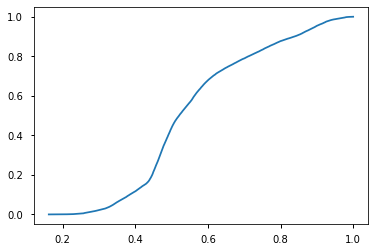

In [129]:
plt.plot(ecdf_e.x, ecdf_e.y)

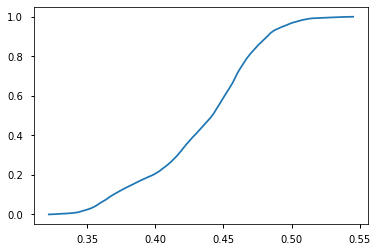

In [130]:
plt.plot(ecdf_f.x, ecdf_f.y)

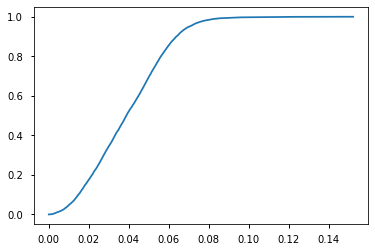

In [126]:
plt.plot(ecdf_v.x, ecdf_v.y)

In [71]:
axes.shape

(3,)

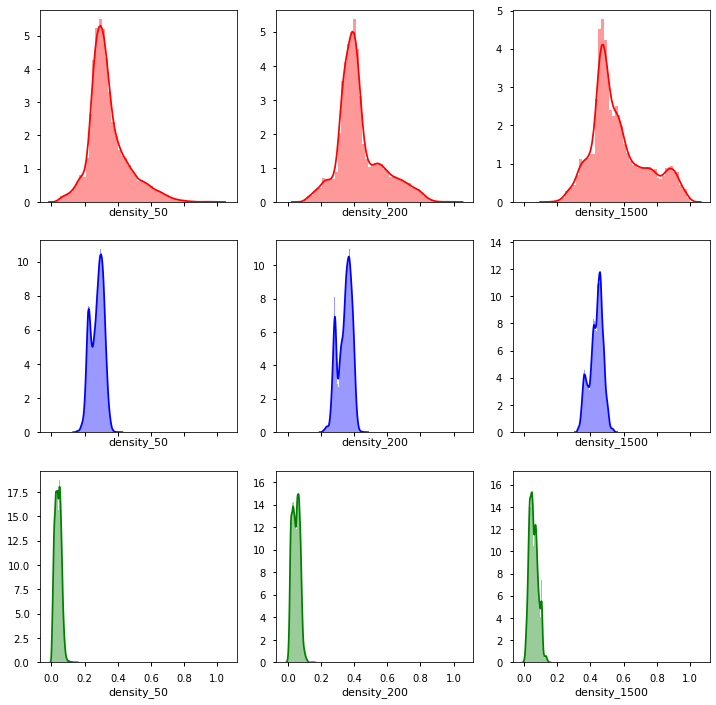

In [115]:
k = "density"
f, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True)
sns.distplot(df.query("label == 0")[k + "_50"], color="r", ax=axes[0,0])
sns.distplot(df.query("label == 1")[k + "_50"], color="b", ax=axes[1,0])
sns.distplot(df.query("label == 2")[k + "_50"], color="g", ax=axes[2,0])

sns.distplot(df.query("label == 0")[k + "_200"], color="r", ax=axes[0,1])
sns.distplot(df.query("label == 1")[k + "_200"], color="b", ax=axes[1,1])
sns.distplot(df.query("label == 2")[k + "_200"], color="g", ax=axes[2,1])

sns.distplot(df.query("label == 0")[k + "_1500"], color="r", ax=axes[0,2])
sns.distplot(df.query("label == 1")[k + "_1500"], color="b", ax=axes[1,2])
sns.distplot(df.query("label == 2")[k + "_1500"], color="g", ax=axes[2,2])

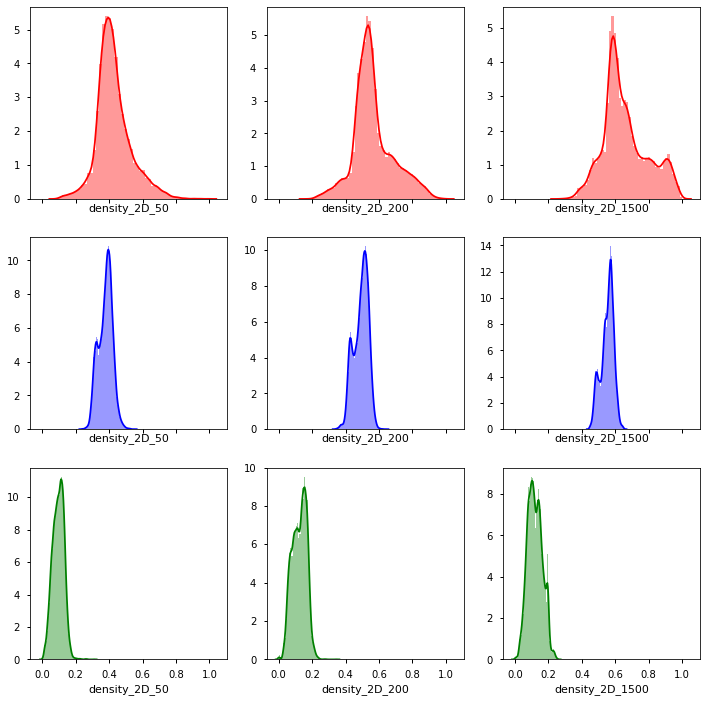

In [116]:
k = "density_2D"
f, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True)
sns.distplot(df.query("label == 0")[k + "_50"], color="r", ax=axes[0,0])
sns.distplot(df.query("label == 1")[k + "_50"], color="b", ax=axes[1,0])
sns.distplot(df.query("label == 2")[k + "_50"], color="g", ax=axes[2,0])

sns.distplot(df.query("label == 0")[k + "_200"], color="r", ax=axes[0,1])
sns.distplot(df.query("label == 1")[k + "_200"], color="b", ax=axes[1,1])
sns.distplot(df.query("label == 2")[k + "_200"], color="g", ax=axes[2,1])

sns.distplot(df.query("label == 0")[k + "_1500"], color="r", ax=axes[0,2])
sns.distplot(df.query("label == 1")[k + "_1500"], color="b", ax=axes[1,2])
sns.distplot(df.query("label == 2")[k + "_1500"], color="g", ax=axes[2,2])

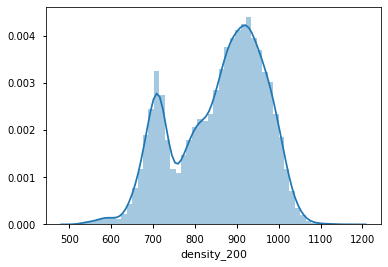

## Labelling Functions

In [50]:
VOISINS = [50, 200, 1500]

In [51]:
def mean_features(df, name, voisins=None):
    if voisins is None:
        voisins = VOISINS
    cols = [name + "_" + str(num) for num in voisins]
    return df[cols].mean()

In [52]:
def diff_voisin_features(df, name, voisins=None):
    if voisins is None:
        voisins = VOISINS
    cols = [name + "_" + str(num) for num in voisins]
    return df[cols[-1]] - df[cols[0]]

In [53]:
def max_value_features(df, name, voisins=None):
    if voisins is None:
        voisins = VOISINS
    cols = [name + "_" + str(num) for num in voisins]
    return df[cols].max()

In [54]:
def gamma(df, voisins=None):
    if voisins is None:
        voisins = VOISINS
    # 1 - (alpha+beta)
    return pd.Series({("gamma_" + str(num)): 1 - (df["alpha_" + str(num)] + df["beta_" + str(num)]) for num in voisins})

In [55]:
@labeling_function()
def verticality(x):
    coeff = mean_features(x, "verticality")
    beta_value = diff_voisin_features(x, "beta")
    if coeff >= 0.5:
        return FALAISE
    if beta_value <= 0.:
        return VEGETATION
    return EBOULIS

In [56]:
# autre "notion" de verticalité, c'est de prendre le ratio e2 / e1 dans un cas 2D (x,y).
# quand la valeur est faible, c'est que la projection sur x,y donne quelque chose
# de très linéaire (e.g. projection d'un plan vertical, comme un mur, sur x,y va donner une droite)
@labeling_function()
def eigenratio_2d(x):
    value = mean_features(x, "eigenvalue_ratio_2D")
    if value < 0.25:
        return FALAISE
    return UNKNOWN

In [57]:
# cette feature doit être normalisé en minxmax_scale
@labeling_function()
def eigenvalue_sum(x):
    value = mean_features(x, "eigenvalue_sum")
    if value >= 0.5:
        return VEGETATION
    if value > 0.1:
        return EBOULIS
    # très petite valeur souvent <= 0.1
    return FALAISE

In [58]:
# cette feature doit être normalisé en minxmax_scale
@labeling_function()
def density_3D(x):
    value = max_value_features(x, "density")
    if value < 0.2:
        return VEGETATION
    if value <= 0.5:
        return FALAISE
    # grande valeur pour éboulis (>0.5)
    return EBOULIS

In [59]:
@labeling_function()
def increasing_gamma(x):
    df_gamma = gamma(x)
    value = diff_voisin_features(df_gamma, "gamma")
    if value >= 0.2:
        return VEGETATION
    if mean_features(df_gamma, "gamma") <= 0.01:
        return FALAISE
    return EBOULIS    

In [60]:
@labeling_function()
def planarity(x):
    value = mean_features(x, "planarity")
    if value <= 0.6:
        return VEGETATION
    value = max_value_features(x, "planarity")
    if value > 0.9:
        return FALAISE
    return EBOULIS

In [64]:
@labeling_function()
def beta(x):
    value = mean_features(x, "beta")
    if value <= 0.6:
        return VEGETATION
    value = max_value_features(x, "beta")
    if value > 0.9:
        return FALAISE
    return EBOULIS

On a ici l'ensemble des *labelling functions* dans une liste

In [62]:
lfs = [verticality, eigenvalue_sum, eigenratio_2d, density_3D, increasing_gamma, planarity, beta]
# lfs = [verticality, increasing_gamma, planarity, beta]

On applique l'ensemble de ces fonctions à l'ensemble des datasets *train* et *dev*

In [63]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)

100%|██████████| 1600/1600 [00:13<00:00, 125.49it/s]


Ici, autant de ligne que de point. Et autant de colonne que de fonctions *labelling* récemment appliquées.

À chaque fois, on a la sortie des *labelling functions* pour chaque point et une indication (une tendance) sur le label des points.

In [65]:
L_train

array([[ 0,  1, -1, ...,  1,  1,  1],
       [ 2,  0, -1, ...,  2,  2,  2],
       [ 0,  1, -1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  0, -1, ...,  0,  2,  2],
       [ 0,  1, -1, ...,  0,  1,  1]])

In [67]:
# quelques stats sur l'ensemble du jeu *L_train*
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
verticality,0,"[0, 1, 2]",1.000000,1.000000,0.657062
eigenvalue_sum,1,"[0, 1, 2]",1.000000,1.000000,0.657062
eigenratio_2d,2,[1],0.388375,0.388375,0.052562
density_3D,3,"[0, 1, 2]",1.000000,1.000000,0.657062
increasing_gamma,4,"[0, 1, 2]",1.000000,1.000000,0.657062
planarity,5,"[0, 1, 2]",1.000000,1.000000,0.657062
beta,6,"[0, 1, 2]",1.000000,1.000000,0.657062


* Polarity : l'ensemble des labels prévus par chaque labelling function pour ce jeu de données
* Coverage : la couverture de la *labelling function*. Si elle renvoie 1, 0 et -1, la couverture ne sera pas à 100% (à cause des UNKNOWN)
* Overlaps : peut être égale à *coverage*. C'est le nombre de fois (en ratio) qu'un label d'une fonction est labélisé par une autre fonction i.e. les ABSTRAIN / UNKNOWN
* Conflits : le nombre de fois (en ratio) qu'un label est différent d'un autre label prédit par une autre fonction

In [73]:
a = LFAnalysis(L=L_dev, lfs=lfs)
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
verticality,0,"[0, 1, 2]",1.000,1.000,0.6850,798,68,0.678750
eigenvalue_sum,1,"[0, 1, 2]",1.000,1.000,0.6850,664,2,0.415000
eigenratio_2d,2,[1],0.355,0.355,0.0475,532,36,0.936620
density_3D,3,"[0, 1, 2]",1.000,1.000,0.6850,1049,0,0.848125
increasing_gamma,4,"[0, 1, 2]",1.000,1.000,0.6850,764,0,0.758750
planarity,5,"[0, 1, 2]",1.000,1.000,0.6850,898,17,0.679375
beta,6,"[0, 1, 2]",1.000,1.000,0.6850,855,24,0.611875


Petit bug sur correct & incorrect. Le calcul de la matrice de confusion dans le code, part du principe qu'on aura forcément des labels -1 aka `ABSTAIN` ou `UNKNOWN` en prédiction. Mais si on n'en a pas, il coupe la matrice de confusion et perd de l'information. Pour le bug, c'est ici https://github.com/snorkel-team/snorkel/issues/1446 Une PR existe et est en cours de relecture.

* Correct : nombre de bonnes prédictions (somme de la diagonale de la matrice de confusion par labelling function)
* Incorrect : nombre de mauvaise prédiction (issue de la matrice de confusion)
* Emp. Acc (empirical accuracy) : on enlève tous les -1 et on regarde la précision empirique total bon / total

In [85]:
L_valid = applier.apply(df=df_valid)

100%|██████████| 3000/3000 [00:27<00:00, 107.77it/s]


Modèle **génératif**. Il va constuire une suite de poids (issus d'un réseau de neurone) pour ensuite sortir une distribution de probabilités des labels pour chaque point (issu d'autre jeux que le *train*)

In [87]:
label_model = LabelModel(cardinality=3, verbose=True)

In [88]:
label_model.fit(L_train=L_train, n_epochs=5000, lr=0.001, log_freq=100, seed=123)

[21:32:46] label_model.fit (INFO) - Computing O...
[21:32:46] label_model.fit (INFO) - Estimating \mu...
[21:32:46] logger.log (INFO) - [0 epochs]: TRAIN:[loss=7.359]
[21:32:47] logger.log (INFO) - [100 epochs]: TRAIN:[loss=0.370]
[21:32:47] logger.log (INFO) - [200 epochs]: TRAIN:[loss=0.222]
[21:32:47] logger.log (INFO) - [300 epochs]: TRAIN:[loss=0.154]
[21:32:47] logger.log (INFO) - [400 epochs]: TRAIN:[loss=0.108]
[21:32:47] logger.log (INFO) - [500 epochs]: TRAIN:[loss=0.083]
[21:32:47] logger.log (INFO) - [600 epochs]: TRAIN:[loss=0.071]
[21:32:47] logger.log (INFO) - [700 epochs]: TRAIN:[loss=0.065]
[21:32:47] logger.log (INFO) - [800 epochs]: TRAIN:[loss=0.062]
[21:32:47] logger.log (INFO) - [900 epochs]: TRAIN:[loss=0.060]
[21:32:47] logger.log (INFO) - [1000 epochs]: TRAIN:[loss=0.059]
[21:32:47] logger.log (INFO) - [1100 epochs]: TRAIN:[loss=0.058]
[21:32:48] logger.log (INFO) - [1200 epochs]: TRAIN:[loss=0.058]
[21:32:48] logger.log (INFO) - [1300 epochs]: TRAIN:[loss=0.05

Calcul de la métrique de précision sur les labels à prévoir (jeu de **validation**). Cette précision n'est le fait uniquement de la construction des *labeling functions* et de ce réseaux de neurones dit "génératif".

In [89]:
label_model_acc = label_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     86.1%


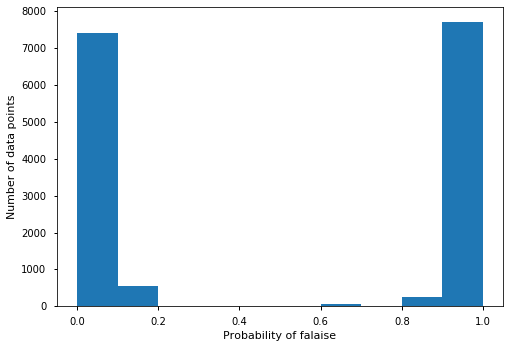

In [90]:
def plot_probabilities_histogram(Y, name):
    plt.hist(Y, bins=10)
    plt.xlabel(f"Probability of {name}")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, FALAISE], "falaise")

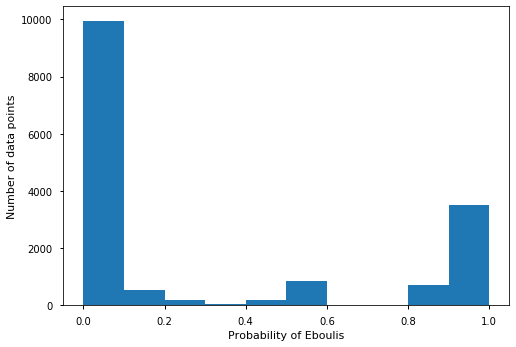

In [91]:
plot_probabilities_histogram(probs_train[:, EBOULIS], "Eboulis")

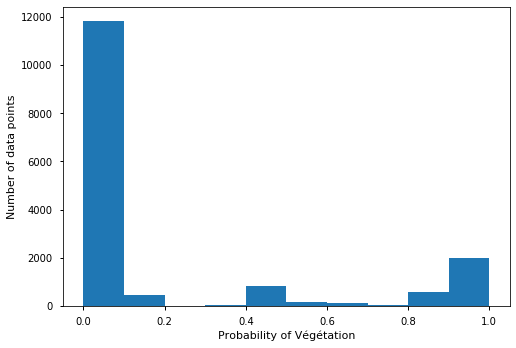

In [92]:
plot_probabilities_histogram(probs_train[:, VEGETATION], "Végétation")

In [93]:
# filtre sur les données non labélisées (UNKNOWN)
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [94]:
df_train_filtered.shape, probs_train_filtered.shape

((16000, 73), (16000, 3))

## On entraine un modèle discriminant

In [95]:
# This next cell makes our Keras results reprodbucible. You can ignore it.
import random

import numpy as np
import tensorflow as tf


seed = 1
np.random.seed(seed)
random.seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)

from tensorflow.keras import backend as K

tf.set_random_seed(seed)
sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [96]:
# celles qui sont corrélées à certaines, les z- accumulation features, etc.
def complete_with_voisin(name, neighbors):
    return [name + "_{}".format(x) for x in neighbors]

drop_cols = ["planarity", "eigenvalue_ratio_2D", "bin_z_range", "bin_z_std", "bin_density",
             "eigenvalue_sum_2D", "eigenvalue_sum", "radius_2D", "std_dev", "density_2D",
             "scattering", "omnivariance", "curvature_change"]
full_cols_to_drop = sum((complete_with_voisin(x, [50, 200, 1500]) for x in drop_cols), [])
full_cols_to_drop

['planarity_50',
 'planarity_200',
 'planarity_1500',
 'eigenvalue_ratio_2D_50',
 'eigenvalue_ratio_2D_200',
 'eigenvalue_ratio_2D_1500',
 'bin_z_range_50',
 'bin_z_range_200',
 'bin_z_range_1500',
 'bin_z_std_50',
 'bin_z_std_200',
 'bin_z_std_1500',
 'bin_density_50',
 'bin_density_200',
 'bin_density_1500',
 'eigenvalue_sum_2D_50',
 'eigenvalue_sum_2D_200',
 'eigenvalue_sum_2D_1500',
 'eigenvalue_sum_50',
 'eigenvalue_sum_200',
 'eigenvalue_sum_1500',
 'radius_2D_50',
 'radius_2D_200',
 'radius_2D_1500',
 'std_dev_50',
 'std_dev_200',
 'std_dev_1500',
 'density_2D_50',
 'density_2D_200',
 'density_2D_1500',
 'scattering_50',
 'scattering_200',
 'scattering_1500',
 'omnivariance_50',
 'omnivariance_200',
 'omnivariance_1500',
 'curvature_change_50',
 'curvature_change_200',
 'curvature_change_1500']

In [100]:
X_train = df_train.drop(columns=["x", "y", "z", "r", "g", "b", "label"] + full_cols_to_drop)
X_dev = df_dev.drop(columns=["x", "y", "z",  "r", "g", "b", "label"] + full_cols_to_drop)
X_valid = df_valid.drop(columns=["x", "y", "z",  "r", "g", "b", "label"] + full_cols_to_drop)
X_test = df_test.drop(columns=["x", "y", "z",  "r", "g", "b", "label"] + full_cols_to_drop)

Ça se passe bien mieux quand j'enlève un certain nombre de *features*. Sans ça, la loss, dès la 1ere époque est à `NaN` et le modèle ne converge pas. Il sort évidemment des métriques de précision aux alentours 33% (une chance sur trois labels). Je cherche encore les raisons.

* Est-ce qu'on a un problème avec trop de dimensions et une architecture non adaptée. Le fait d'enlever des colonnes permet de palier au soucis
* J'ai retiré, comme pour la régression logistique, des colonnes a priori colinéaire. Est-ce que cela peut avoir un impact dans la descente du gradient ?

In [101]:
# X_train = df_train.drop(columns=["x", "y", "z", "label"])
# X_dev = df_dev.drop(columns=["x", "y", "z", "label"])
# X_valid = df_valid.drop(columns=["x", "y", "z", "label"])
# X_test = df_test.drop(columns=["x", "y", "z", "label"])

In [102]:
list(sorted(X_train.columns))

['alpha_1500',
 'alpha_200',
 'alpha_50',
 'anisotropy_1500',
 'anisotropy_200',
 'anisotropy_50',
 'beta_1500',
 'beta_200',
 'beta_50',
 'density_1500',
 'density_200',
 'density_50',
 'eigenentropy_1500',
 'eigenentropy_200',
 'eigenentropy_50',
 'linearity_1500',
 'linearity_200',
 'linearity_50',
 'radius_1500',
 'radius_200',
 'radius_50',
 'verticality_1500',
 'verticality_200',
 'verticality_50',
 'z_range_1500',
 'z_range_200',
 'z_range_50']

In [103]:
from functools import partial


def baseline_model(input_dim):
    # create model
    model = tf.keras.Sequential()
    activation_name = "relu"
    #model.add(tf.keras.layers.Dense(64, input_dim=input_dim, activation=activation_name))
    #model.add(tf.keras.layers.Dense(32, input_dim=input_dim, activation=activation_name))
    model.add(tf.keras.layers.Dense(16, activation=activation_name, input_shape=(input_dim,)))
    model.add(tf.keras.layers.Dense(16, activation=activation_name))
    model.add(tf.keras.layers.Dense(8, activation=activation_name))
    model.add(tf.keras.layers.Dense(units=3,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                    activation='softmax'))
    # opt = tf.keras.optimizers.Adam(lr=0.005)
    # opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipvalue=0.5)
    # opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1.)
    # Compile model
    # model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    


def get_keras_early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=5, verbose=1, restore_best_weights=True
    )



In [104]:
X_valid.shape, Y_valid.shape, X_train.shape, probs_train_filtered.shape

((3000, 27), (3000,), (16000, 27), (16000, 3))

In [105]:
probs_train_filtered[:4], probs_train[:4]

(array([[1.67958526e-02, 9.83013045e-01, 1.91101928e-04],
        [1.58300370e-03, 1.08340749e-10, 9.98416996e-01],
        [1.15476282e-03, 9.97821959e-01, 1.02327835e-03],
        [7.75792032e-08, 9.98616706e-01, 1.38321677e-03]]),
 array([[1.67958526e-02, 9.83013045e-01, 1.91101928e-04],
        [1.58300370e-03, 1.08340749e-10, 9.98416996e-01],
        [1.15476282e-03, 9.97821959e-01, 1.02327835e-03],
        [7.75792032e-08, 9.98616706e-01, 1.38321677e-03]]))

In [106]:
Y_valid

array([1, 1, 1, ..., 0, 1, 1])

In [107]:
preds_to_probs(Y_valid, 3)  # one-hot encoder

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [108]:
kmodel = KerasClassifier(build_fn=partial(baseline_model, input_dim=X_train.shape[1]),
                         epochs=20,
                         # batch_size=5,
                         validation_data=(preprocessing.scale(X_valid), preds_to_probs(Y_valid, 3)),
                         #validation_data=(X_valid, preds_to_probs(Y_valid, 3)),
                         callbacks=[get_keras_early_stopping()],
                         verbose=1)

In [109]:
kmodel.fit(x=preprocessing.scale(X_train), y=probs_train)
# kmodel.fit(x=X_train, y=probs_train)

[21:39:00] deprecation.new_func (WARNING) - From /home/dag/.local/share/virtualenvs/snorkel-tuto/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 16000 samples, validate on 3000 samples
Epoch 1/20
16000/16000 [==============================] - 1s 58us/sample - loss: 0.3708 - acc: 0.8672 - val_loss: 0.1765 - val_acc: 0.9237
Epoch 2/20
16000/16000 [==============================] - 1s 39us/sample - loss: 0.2352 - acc: 0.9230 - val_loss: 0.2297 - val_acc: 0.8877
Epoch 3/20
16000/16000 [==============================] - 1s 39us/sample - loss: 0.2148 - acc: 0.9319 - val_loss: 0.2393 - val_acc: 0.8870
Epoch 4/20
16000/16000 [==============================] - 1s 39us/sample - loss: 0.2057 - acc: 0.9367 - val_loss: 0.2288 - val_acc: 0.8847
Epoch 5/20
16000/16000 [==============================] - 1s 40us/sample - loss: 0.1997 - acc: 0.9414 - val_loss: 0.2570 - val_acc: 0.8833
Epoch 6/20
16000/16000 [==============================] - 1s 40us/sample - loss: 0.1964 - acc: 0.9431 - val_loss: 0.4211 - val_acc: 0.8453
Epoch 00006: early stopping


In [110]:
[w.shape for w in kmodel.model.get_weights()]

[(27, 16), (16,), (16, 16), (16,), (16, 8), (8,), (8, 3), (3,)]

In [111]:
# kmodel.model.get_weights()

In [112]:
X_train.shape

(16000, 27)

In [113]:
kmodel.predict(X_test.values[:5])

5/5 [==============================] - 0s 3ms/sample


array([0, 0, 0, 0, 0])

In [114]:
# preds_test = kmodel.predict(X_test)
preds_test = kmodel.predict(preprocessing.scale(X_test))

1000/1000 [==============================] - 0s 9us/sample


In [115]:
from snorkel.analysis import metric_score

# preds_test = keras_model.predict(x=X_test).argmax(axis=1)
test_acc = metric_score(golds=Y_test, preds=preds_test, metric="accuracy")
print(f"Test Accuracy: {test_acc * 100:.1f}%")

Test Accuracy: 91.6%


## Prédiction sur toute la scène

In [116]:
features.columns

Index(['x', 'y', 'z', 'alpha_50', 'beta_50', 'radius_50', 'z_range_50',
       'std_dev_50', 'density_50', 'verticality_50', 'curvature_change_50',
       'linearity_50', 'planarity_50', 'scattering_50', 'omnivariance_50',
       'anisotropy_50', 'eigenentropy_50', 'eigenvalue_sum_50', 'radius_2D_50',
       'density_2D_50', 'eigenvalue_sum_2D_50', 'eigenvalue_ratio_2D_50', 'r',
       'g', 'b', 'alpha_200', 'beta_200', 'radius_200', 'z_range_200',
       'std_dev_200', 'density_200', 'verticality_200', 'curvature_change_200',
       'linearity_200', 'planarity_200', 'scattering_200', 'omnivariance_200',
       'anisotropy_200', 'eigenentropy_200', 'eigenvalue_sum_200',
       'radius_2D_200', 'density_2D_200', 'eigenvalue_sum_2D_200',
       'eigenvalue_ratio_2D_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'std_dev_1500', 'density_1500', 'verticality_1500',
       'curvature_change_1500', 'linearity_1500', 'planarity_1500',
       'scattering_1500', 'omnivari

In [117]:
scene_drop_cols = ["planarity", "eigenvalue_ratio_2D",
                   "eigenvalue_sum_2D", "eigenvalue_sum", "radius_2D", "std_dev", "density_2D",
                   "scattering", "omnivariance", "curvature_change"]
scene_full_cols_to_drop = sum((complete_with_voisin(x, [50, 200, 1500]) for x in scene_drop_cols), [])
scene_full_cols_to_drop

['planarity_50',
 'planarity_200',
 'planarity_1500',
 'eigenvalue_ratio_2D_50',
 'eigenvalue_ratio_2D_200',
 'eigenvalue_ratio_2D_1500',
 'eigenvalue_sum_2D_50',
 'eigenvalue_sum_2D_200',
 'eigenvalue_sum_2D_1500',
 'eigenvalue_sum_50',
 'eigenvalue_sum_200',
 'eigenvalue_sum_1500',
 'radius_2D_50',
 'radius_2D_200',
 'radius_2D_1500',
 'std_dev_50',
 'std_dev_200',
 'std_dev_1500',
 'density_2D_50',
 'density_2D_200',
 'density_2D_1500',
 'scattering_50',
 'scattering_200',
 'scattering_1500',
 'omnivariance_50',
 'omnivariance_200',
 'omnivariance_1500',
 'curvature_change_50',
 'curvature_change_200',
 'curvature_change_1500']

In [118]:
scene = features.drop(columns=["x", "y", "z"] + ["r", "g", "b"] + scene_full_cols_to_drop)

In [119]:
X_train.columns

Index(['alpha_50', 'beta_50', 'radius_50', 'z_range_50', 'density_50',
       'verticality_50', 'linearity_50', 'anisotropy_50', 'eigenentropy_50',
       'alpha_200', 'beta_200', 'radius_200', 'z_range_200', 'density_200',
       'verticality_200', 'linearity_200', 'anisotropy_200',
       'eigenentropy_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'density_1500', 'verticality_1500', 'linearity_1500',
       'anisotropy_1500', 'eigenentropy_1500'],
      dtype='object')

In [120]:
scene.columns

Index(['alpha_50', 'beta_50', 'radius_50', 'z_range_50', 'density_50',
       'verticality_50', 'linearity_50', 'anisotropy_50', 'eigenentropy_50',
       'alpha_200', 'beta_200', 'radius_200', 'z_range_200', 'density_200',
       'verticality_200', 'linearity_200', 'anisotropy_200',
       'eigenentropy_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'density_1500', 'verticality_1500', 'linearity_1500',
       'anisotropy_1500', 'eigenentropy_1500'],
      dtype='object')

In [121]:
# label = kmodel.predict(scene)
label = kmodel.predict(preprocessing.scale(scene))

672193/672193 [==============================] - 7s 10us/sample


In [122]:
pd.Series(label).groupby(label).count()

0    252755
1    289316
2    130122
dtype: int64

In [126]:
def savelas(input_file, data, output_file):
    import laspy
    with laspy.file.File(input_file, mode="r") as input_las:
        outfile = laspy.file.File(
            output_file, mode="w", header=input_las.header
        )
        outfile.x = data.x
        outfile.y = data.y
        outfile.z = data.z
        outfile.red = data.r
        outfile.green = data.g
        outfile.blue = data.b
        outfile.close()

In [127]:
def colorize_clusters(points, labels, colors):
    """Associated a (r, g, b) color for each record of a dataframe, depending
    on the cluster id

    Parameters
    ----------
    points : pandas.DataFrame
        Set of (x, y, z) points
    labels : np.array or pd.Series
    colors : dict
        Each label, one color

    Returns
    -------
    pandas.DataFrame
        Colorized points, i.e. set of (x, y, z, r, g, b) clustered points
    """
    colors = np.array([colors[l] for l in labels]) * 256
    colors = pd.DataFrame(colors, columns=["r", "g", "b"], dtype=np.uint8)
    return points.join(colors)

In [128]:
LABELS

{'eboulis': 0, 'falaise': 1, 'vegetation': 2}

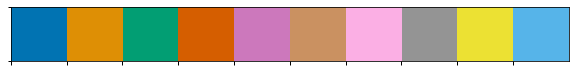

In [129]:
sns.palplot(sns.color_palette("colorblind"))

In [130]:
palette = sns.color_palette("colorblind")
colors = {0: palette[7],  # éboulis / gris
          1: palette[0],  # falaise / bleu
          2: palette[2]}  # végétation / vert

In [131]:
outdf = colorize_clusters(features[COORDS], label, colors)

In [132]:
savelas(DATADIR / "input" / SCENE_FILE, outdf, "pombourg-segmentation-snorkel-without-rgb-2.las")